<a href="https://colab.research.google.com/github/Br-alexis73/Face_recognition/blob/master/fr_experiment_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'lfw-dataset:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F26922%2F34595%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240419%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240419T152011Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3Db4ec61946419ca8b830a0f4613cac81dffb050d7d712972d73e73a8d24cc40a231fb1a47a2c7bce99a68ff93e9ac40d5a337ede5b14e8940c63ba216337c90b4cc432075b2f24e158971a25f9ecb52e84512e1cdc8473afcdfc20275099542b8cc23208d379bed1a7e644e96a929b7dbb91a7019f5331c94ea9f46d05bdd60badb9169961ed1faa90ae1290e3919c42a5736aa4fd68b941df0dac0e6957e4528a6663da154303292f0925fe7bc92d10ad202845647f7a1eff66f586604bb52c0626b2d95f3daf452d5dae6be3e0f2daf1e3177513be89acda9a7114a083009f77cf36a5edd56f41bb1bf1ba424974542d3b8bd7ac3ec5ab7122a096e033e4df9'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 117895655 bytes downloaded
Downloaded and uncompressed: lfw-dataset
Data source import complete.


In [2]:
import os
import pandas as pd

dataset_path = '../input/lfw-dataset/lfw-deepfunneled/lfw-deepfunneled'

# Generate a list of (name, image count) tuples
names_images = []

for name in os.listdir(dataset_path):
    directory = os.path.join(dataset_path, name)
    if os.path.isdir(directory):
        image_count = len([i for i in os.listdir(directory) if i.endswith('.jpg')])
        if image_count >= 20:  # Check if the count is 10 or more
            names_images.append((name, image_count))

# Count the number of people with 10 or more images
number_of_people = len(names_images)
print(f"Number of people with 20 or more images: {number_of_people}")

# Create a DataFrame
lfw_allnames = pd.DataFrame(names_images, columns=['name', 'images'])

# Save the DataFrame to a CSV file
lfw_csv_path = '../input/lfw-dataset/lfw_allnames.csv'
lfw_allnames.to_csv(lfw_csv_path, index=False)

print(f"CSV file created at: {lfw_csv_path}")

Number of people with 20 or more images: 62
CSV file created at: ../input/lfw-dataset/lfw_allnames.csv


In [3]:
import os
import shutil
import pandas as pd

# Define the path to the dataset and the new directory
dataset_path = '../input/lfw-dataset/lfw-deepfunneled/lfw-deepfunneled'
new_dir_path = '../lfw-data-experiment'
csv_path = '../input/lfw-dataset/lfw_allnames.csv'

# Read the CSV file to get the list of names
all_names_df = pd.read_csv(csv_path)
names_list = all_names_df['name'].tolist()

# Create the new directory if it doesn't exist
if not os.path.exists(new_dir_path):
    os.makedirs(new_dir_path)

# Move the folders
for name in names_list:
    source_folder = os.path.join(dataset_path, name)
    destination_folder = os.path.join(new_dir_path, name)

    # Check if the destination folder already exists
    if os.path.exists(destination_folder):
        # Remove the existing folder
        shutil.rmtree(destination_folder)

    # Check if the source folder exists before moving
    if os.path.exists(source_folder):
        shutil.move(source_folder, destination_folder)
    else:
        print(f"Folder for {name} does not exist in the dataset path.")

print("Folders moved successfully.")


Error: Destination path '../lfw-data-experiment/Luiz_Inacio_Lula_da_Silva/Luiz_Inacio_Lula_da_Silva' already exists

In [4]:
import os

# Correct path according to your folder structure
lfw_data_experiment = '../lfw-data-experiment'

people_data = os.listdir(lfw_data_experiment)
print(len(people_data))

people = []
for item in people_data:
    all_names = os.listdir(lfw_data_experiment + '/' + item)
    for person in all_names:
        people.append((item, lfw_data_experiment + '/' + item + '/' + person))

print(people)


62
[('Luiz_Inacio_Lula_da_Silva', '../lfw-data-experiment/Luiz_Inacio_Lula_da_Silva/Luiz_Inacio_Lula_da_Silva'), ('Luiz_Inacio_Lula_da_Silva', '../lfw-data-experiment/Luiz_Inacio_Lula_da_Silva/Luiz_Inacio_Lula_da_Silva_0008.jpg'), ('Luiz_Inacio_Lula_da_Silva', '../lfw-data-experiment/Luiz_Inacio_Lula_da_Silva/Luiz_Inacio_Lula_da_Silva_0031.jpg'), ('Luiz_Inacio_Lula_da_Silva', '../lfw-data-experiment/Luiz_Inacio_Lula_da_Silva/Luiz_Inacio_Lula_da_Silva_0003.jpg'), ('Luiz_Inacio_Lula_da_Silva', '../lfw-data-experiment/Luiz_Inacio_Lula_da_Silva/Luiz_Inacio_Lula_da_Silva_0024.jpg'), ('Luiz_Inacio_Lula_da_Silva', '../lfw-data-experiment/Luiz_Inacio_Lula_da_Silva/Luiz_Inacio_Lula_da_Silva_0037.jpg'), ('Luiz_Inacio_Lula_da_Silva', '../lfw-data-experiment/Luiz_Inacio_Lula_da_Silva/Luiz_Inacio_Lula_da_Silva_0006.jpg'), ('Luiz_Inacio_Lula_da_Silva', '../lfw-data-experiment/Luiz_Inacio_Lula_da_Silva/Luiz_Inacio_Lula_da_Silva_0007.jpg'), ('Luiz_Inacio_Lula_da_Silva', '../lfw-data-experiment/Luiz_In

In [5]:
import pandas as pd

# Create a DataFrame from the list of tuples
people_df = pd.DataFrame(people, columns=['person', 'path'])

# Count the number of samples for each person
person_count = people_df['person'].value_counts()

print("Total number of images of people in the dataset: ", len(people_df))
print("Samples in each category: ")
print(person_count)


Total number of images of people in the dataset:  3085
Samples in each category: 
person
George_W_Bush        531
Colin_Powell         237
Tony_Blair           145
Donald_Rumsfeld      122
Gerhard_Schroeder    110
                    ... 
Igor_Ivanov           21
Michael_Bloomberg     21
Jiang_Zemin           21
Paul_Bremer           21
Angelina_Jolie        21
Name: count, Length: 62, dtype: int64


In [6]:
import cv2
import os

# Specify the base path to the dataset containing subdirectories for each person
path = '../lfw-data-experiment'

# Specify the desired size for the images
im_size = 250

# Initialize lists to store the images and labels
images = []
labels = []

# List all the people's subdirectories in the base dataset folder
people_data = os.listdir(path)

# Loop through each subdirectory corresponding to a person
for person_name in people_data:
    # Construct the path to the person's subdirectory
    person_path = os.path.join(path, person_name)

    # List all image filenames in the person's subdirectory
    filenames = [f for f in os.listdir(person_path) if f.endswith(('.jpg'))]

    # Loop through each image filename
    for f in filenames:
        # Construct the full path to the image
        file_path = os.path.join(person_path, f)

        # Read the image from the file
        img = cv2.imread(file_path)

        # Resize the image
        img = cv2.resize(img, (im_size, im_size))

        # Append the image to the images list
        images.append(img)

        # Append the label (person's name) to the labels list
        labels.append(person_name)


In [7]:
import numpy as np

images = np.array(images)

images = images.astype('float32') / 255.0
images.shape

(3023, 250, 250, 3)

In [8]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

y = people_df['person'].values
#print(y[:5])

y_labelencoder = LabelEncoder ()
y = y_labelencoder.fit_transform (y)
print (y)

[40 40 40 ... 50 50 50]


In [9]:
# First, convert string labels to integers using LabelEncoder
label_encoder = LabelEncoder()
y_integers = label_encoder.fit_transform(y)
print(y_integers)

# Now reshape y to be a 2D array, as required by OneHotEncoder
y_integers = y_integers.reshape(-1, 1)

# Create the OneHotEncoder instance
onehot_encoder = OneHotEncoder(sparse=False)  # Use sparse=False to get a dense array

# Apply OneHotEncoder to the integer array
Y = onehot_encoder.fit_transform(y_integers)

# Checking the shape of the result
print(Y.shape)

[40 40 40 ... 50 50 50]
(3085, 62)


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [12]:
print(len(images))
print(len(Y))


3023
3085


In [15]:
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split


images, Y = shuffle(images, Y, random_state=1)

train_x, test_x, train_y, test_y = train_test_split(images, Y, test_size=0.3, random_state=415)

#inpect the shape of the training and testing.
print(train_x.shape)
print(train_y.shape)
print(test_x.shape)
print(test_y.shape)

(2116, 250, 250, 3)
(2116, 62)
(907, 250, 250, 3)
(907, 62)


In [32]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, ZeroPadding2D, Activation


In [35]:
# Same model setup as before
multi_classifier = Sequential()

# Block 1
multi_classifier.add(ZeroPadding2D((1,1), input_shape=(250, 250, 3)))
multi_classifier.add(Conv2D(64, (3, 3), activation='relu'))
multi_classifier.add(ZeroPadding2D((1,1)))
multi_classifier.add(Conv2D(64, (3, 3), activation='relu'))
multi_classifier.add(MaxPooling2D((2,2), strides=(2,2)))

#Block2
multi_classifier.add(ZeroPadding2D((1,1)))
multi_classifier.add(Conv2D(128, (3, 3), activation='relu'))
multi_classifier.add(ZeroPadding2D((1,1)))
multi_classifier.add(Conv2D(128, (3, 3), activation='relu'))
multi_classifier.add(MaxPooling2D((2,2), strides=(2,2)))

#Block3
multi_classifier.add(ZeroPadding2D((1,1)))
multi_classifier.add(Conv2D(256, (3, 3), activation='relu'))
multi_classifier.add(ZeroPadding2D((1,1)))
multi_classifier.add(Conv2D(256, (3, 3), activation='relu'))
multi_classifier.add(ZeroPadding2D((1,1)))
multi_classifier.add(Conv2D(256, (3, 3), activation='relu'))
multi_classifier.add(MaxPooling2D((2,2), strides=(2,2)))

#Block 4
multi_classifier.add(ZeroPadding2D((1,1)))
multi_classifier.add(Conv2D(512, (3, 3), activation='relu'))
multi_classifier.add(ZeroPadding2D((1,1)))
multi_classifier.add(Conv2D(512, (3, 3), activation='relu'))
multi_classifier.add(ZeroPadding2D((1,1)))
multi_classifier.add(Conv2D(512, (3, 3), activation='relu'))
multi_classifier.add(MaxPooling2D((2,2), strides=(2,2)))

# Block 5
multi_classifier.add(ZeroPadding2D((1,1)))
multi_classifier.add(Conv2D(512, (3, 3), activation='relu'))
multi_classifier.add(ZeroPadding2D((1,1)))
multi_classifier.add(Conv2D(512, (3, 3), activation='relu'))
multi_classifier.add(ZeroPadding2D((1,1)))
multi_classifier.add(Conv2D(512, (3, 3), activation='relu'))
multi_classifier.add(MaxPooling2D((2,2), strides=(2,2)))

# Custom Classifier Layers
multi_classifier.add(Flatten())
multi_classifier.add(Dense(1024, activation='relu'))
multi_classifier.add(Dropout(0.5))
multi_classifier.add(Dense(1024, activation='relu'))
multi_classifier.add(Dropout(0.5))
# Output layer for categorical  classification
multi_classifier.add(Dense(62, activation='softmax'))

# Compile model
multi_classifier.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics=['accuracy'])

In [36]:
multi_history = multi_classifier.fit(train_x, train_y, epochs = 10, batch_size = 32, validation_data = test_x)

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [ ]:
multi_classfier.fit()

In [14]:
from __future__ import print_function
import numpy as np
import warnings

from keras.models import Model
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Input
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import GlobalMaxPooling2D
from keras.layers import GlobalAveragePooling2D
from keras.preprocessing import image
# from keras.utils import layer_utils
# from keras.utils.data_utils import get_file
# from keras import backend as K
# from keras.applications.imagenet_utils import decode_predictions
# from keras.applications.imagenet_utils import preprocess_input
# from keras.applications.imagenet_utils import _obtain_input_shape # this will work for older versions of keras. 2.2.0 or before
# from keras.engine.topology import get_source_inputs

In [16]:
def VGGupdated(input_tensor=None,classes=2):

    img_rows, img_cols = 250, 250   # by default size is 224,224
    img_channels = 3

    img_dim = (img_rows, img_cols, img_channels)

    img_input = Input(shape=img_dim)

    # Block 1
    x = Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv1')(img_input)
    x = Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv2')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool')(x)

    # Block 2
    x = Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv1')(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv2')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool')(x)

    # Block 3
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv1')(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv2')(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv3')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block3_pool')(x)

    # Block 4
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv1')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv2')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv3')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block4_pool')(x)

    # Block 5
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv1')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv2')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv3')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block5_pool')(x)


    # Classification block
    x = Flatten(name='flatten')(x)
    x = Dense(4096, activation='relu', name='fc1')(x)
    x = Dense(4096, activation='relu', name='fc2')(x)
    x = Dense(classes, activation='softmax', name='predictions')(x)

    # Create model.

    model = Model(inputs = img_input, outputs = x, name='VGGdemo')

    return model

In [17]:
model = VGGupdated(classes = 62)

In [18]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [48]:
history = model.fit(train_x, train_y, epochs = 10, batch_size = 32, validation_data=(test_x, test_y) )

Epoch 1/10
67/67 [==============================] - 42s 634ms/step - loss: 3.6708 - accuracy: 0.1711 - val_loss: 3.6469 - val_accuracy: 0.1863
Epoch 2/10
67/67 [==============================] - 40s 597ms/step - loss: 3.6687 - accuracy: 0.1711 - val_loss: 3.6478 - val_accuracy: 0.1863
Epoch 3/10
67/67 [==============================] - 40s 600ms/step - loss: 3.6694 - accuracy: 0.1711 - val_loss: 3.6461 - val_accuracy: 0.1863
Epoch 4/10
67/67 [==============================] - 40s 599ms/step - loss: 3.6695 - accuracy: 0.1711 - val_loss: 3.6455 - val_accuracy: 0.1863
Epoch 5/10
67/67 [==============================] - 40s 599ms/step - loss: 3.6657 - accuracy: 0.1711 - val_loss: 3.6445 - val_accuracy: 0.1863
Epoch 6/10
67/67 [==============================] - 40s 591ms/step - loss: 3.6674 - accuracy: 0.1711 - val_loss: 3.6420 - val_accuracy: 0.1863
Epoch 7/10
67/67 [==============================] - 39s 590ms/step - loss: 3.6682 - accuracy: 0.1711 - val_loss: 3.6428 - val_accuracy: 0.1863

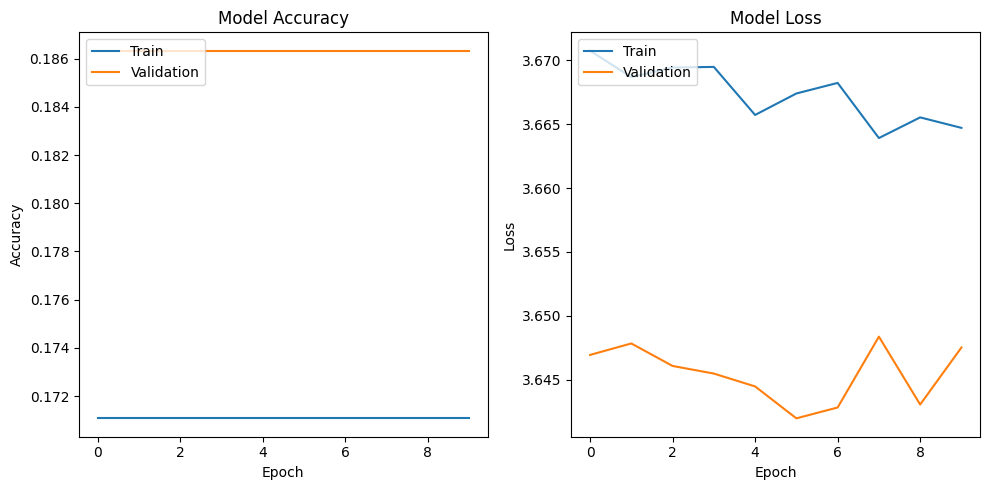

In [49]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])  # Now this line is active
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])  # And this line is active
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.tight_layout()
plt.show()


In [51]:
preds = model.evaluate(test_x, test_y)


29/29 [==============================] - 5s 158ms/step - loss: 3.6475 - accuracy: 0.1863


In [46]:
preds = model.predict(test_x)
# print ("Loss = " + str(preds[0]))

29/29 [==============================] - 5s 162ms/step


In [25]:
from keras.preprocessing import image

# create a function to predict class of images in a directory, given a trained classifier
def predictions(dir_name,classifier,binary):
    # dir_name should include name of predicted invididual - could edit this to iterate through folders in future
    predictions = []
    for im in os.listdir(dir_name):
        test_image = image.load_img(dir_name + str(im), target_size = (250,250))
        test_image = image.img_to_array(test_image)
        test_image = np.expand_dims(test_image, axis = 0)
        if(binary is True):
            result = float(str(classifier.predict(test_image))[2])
        else:
            result = np.argmax(classifier.predict(test_image))
        predictions.append(result)
    return(predictions)

In [26]:
def prec_acc(predictions_frame):
    precision = []
    accuracy = []
    recall = []
    for i in range(len(set(predictions_frame['Predictions']))):
        tp = predictions_frame[np.logical_and(predictions_frame['Actual'] == i, predictions_frame['Predictions'] == i)].shape[0]
        tn = predictions_frame[np.logical_and(predictions_frame['Actual'] != i, predictions_frame['Predictions'] != i)].shape[0]
        fp = predictions_frame[np.logical_and(predictions_frame['Actual'] != i, predictions_frame['Predictions'] == i)].shape[0]
        fn = predictions_frame[np.logical_and(predictions_frame['Actual'] == i, predictions_frame['Predictions'] != i)].shape[0]
        total_preds = predictions_frame.shape[0]

        # Check if the denominator for precision is zero
        if (tp + fp) > 0:
            precision.append(tp / (tp + fp))
        else:
            precision.append(0)

        # Accuracy should not cause division by zero since total_preds should not be zero
        accuracy.append((tp + tn) / total_preds)

        # Check if the denominator for recall is zero
        if (tp + fn) > 0:
            recall.append(tp / (tp + fn))
        else:
            recall.append(0)

    return accuracy, precision, recall

Input image shape: (1, 250, 250, 3)


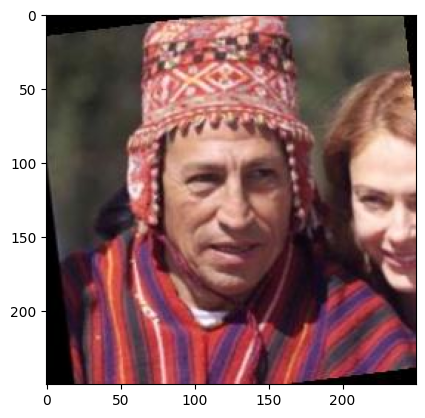

In [53]:
from matplotlib.pyplot import imread
from matplotlib.pyplot import imshow

img_path = '../lfw-data-experiment/Alejandro_Toledo/Alejandro_Toledo_0003.jpg'

img = image.load_img(img_path, target_size=(250, 250))

x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
# x = preprocess_input(x)

print('Input image shape:', x.shape)

my_image = imread(img_path)
imshow(my_image)

In [56]:
test = model.predict(x)

print(test)

1/1 [==============================] - 0s 31ms/step
[[1.24296797e-02 1.20763378e-02 6.64263545e-03 1.39239440e-02
  6.22563343e-03 2.55334452e-02 1.36715779e-02 7.93823507e-03
  9.93747171e-03 9.31926444e-03 7.49098361e-02 1.08909989e-02
  4.42723222e-02 6.95615308e-03 1.46131858e-01 3.76791172e-02
  1.52911209e-02 9.15680453e-03 1.04835080e-02 7.33728753e-03
  1.25628011e-02 2.29868293e-02 6.79305336e-03 1.09659173e-02
  1.79324057e-02 1.90852564e-02 6.04651310e-03 1.70095004e-02
  9.81436577e-03 9.70882829e-03 6.89791050e-03 2.09023412e-02
  1.37923677e-02 9.53652989e-03 1.34390770e-02 2.15400420e-02
  1.08639551e-02 1.35768717e-02 1.02956276e-02 1.24755017e-02
  1.77652538e-02 1.05071804e-02 1.27341421e-02 7.55171431e-03
  7.73441186e-03 1.47208935e-02 5.10870050e-05 6.46805856e-03
  9.83320642e-03 1.02620963e-02 5.02357943e-05 7.12407473e-03
  9.91605595e-03 1.77442729e-02 1.07660964e-02 6.74372911e-03
  8.45388416e-03 1.23898545e-02 4.45036665e-02 1.06285149e-02
  1.84817668e-02 8

29/29 [==============================] - 4s 157ms/step


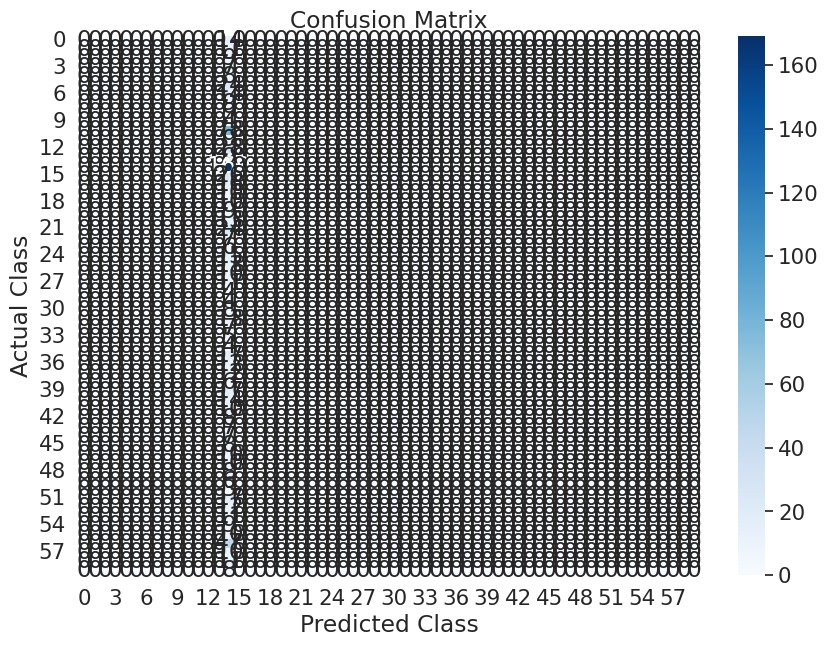

In [65]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import numpy as np

# Assuming test_data is your test dataset
predictions = model.predict(test_x)
predicted_classes = np.argmax(predictions, axis=1)
actual_classes = np.argmax(test_y, axis=1)  # Replace with your actual test labels

# Generate the confusion matrix
cm = confusion_matrix(actual_classes, predicted_classes)

# Plotting the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('Actual Class')
plt.xlabel('Predicted Class')
plt.show()



In [ ]:
from sklearn.metrics import classification_report

# Generate the classification report
report = classification_report(actual_classes, predicted_classes, target_names=your_class_names)

print(report)


In [67]:
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

predictions = model.predict(test_x)
predicted_classes = np.argmax(predictions, axis=1)
actual_classes = np.argmax(test_y, axis=1)

# Generate the classification report.
report = classification_report(actual_classes, predicted_classes)

print(report)

29/29 [==============================] - 4s 157ms/step
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        14
           1       0.00      0.00      0.00        11
           2       0.00      0.00      0.00         9
           3       0.00      0.00      0.00         7
           4       0.00      0.00      0.00         8
           5       0.00      0.00      0.00        24
           6       0.00      0.00      0.00        14
           7       0.00      0.00      0.00         9
           8       0.00      0.00      0.00         9
           9       0.00      0.00      0.00         4
          10       0.00      0.00      0.00        78
          11       0.00      0.00      0.00         9
          12       0.00      0.00      0.00        28
          13       0.00      0.00      0.00         9
          14       0.19      1.00      0.31       169
          15       0.00      0.00      0.00        26
          16       0.00   

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import numpy as np

# Shuffle and split the dataset.
images, Y = shuffle(images, Y, random_state=1)
train_x, test_x, train_y, test_y = train_test_split(images, Y, test_size=0.3, random_state=415)

# Assuming 'model' is your pre-built and compiled model and it's already trained.
predictions = model.predict(test_x)
predicted_classes = np.argmax(predictions, axis=1)
actual_classes = np.argmax(test_y, axis=1)

# Assuming you have a list of class names corresponding to the indices.
class_names = ['class1', 'class2', 'class3', ..., 'class62']  # replace with your actual class names

# Generate the classification report with class names.
report = classification_report(actual_classes, predicted_classes, target_names=class_names)

print(report)